# Bibliothèques

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 51)
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn : apprentissage automatique
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import set_config # Pour afficher les pipelines
set_config(display='diagram')
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Learning curve avec yellowbrick
from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ROCAUC

import scipy.stats as stats
import pylab


# import warnings
# warnings.filterwarnings("ignore")

# Catalogue des fonctions

## Datavisualisation

In [2]:
# Datavisualisation

def analyse_dtypes_object(data):
    '''Modalités pour les variables quantitatives triées par nombre
    '''
    return data.select_dtypes(include=('object')).nunique().sort_values(ascending=False)


def analyse_dtypes_numeric(data):
    '''Modalités pour les variables qualitatives triées par nombre
    '''
    return data.select_dtypes(include=('integer', 'float')).nunique().sort_values(ascending=False)


def analyse_target(data):
    '''Répartition en % des modalités de la target
    '''
    number = data.readmitted.value_counts()
    percentage = data.readmitted.value_counts(normalize=True).round(3)*100
    analyse_target = {'number': number, '%': percentage}
    analyse_target_1 = pd.DataFrame(analyse_target)
    return analyse_target_1


def map_missing_values(data):
    '''Cartographie des valeurs manquantes du dataset (couleur noire)
    '''
    plt.figure(figsize=(17,7))
    heatmap = sns.heatmap(data.isna(), cbar=False, cmap="Blues")
    heatmap.set_title('Heatmap des valeurs manquantes du dataset',
    fontdict={'fontsize':18}, pad=16);

    
def check_null_values(df):
    ''' Pourcentage de valeurs nulles par colonne
    '''
    nb_null = df.isnull().sum().sort_values(ascending=False).head(10)
    percentage_null = df.isnull().sum()*100/len(df)
    percentage_null = percentage_null.sort_values(ascending=False).head(10).round(1)
    null = {'nombre_null' : nb_null,'%_null' : percentage_null}
    data = pd.DataFrame(data = null)
    return data

## Preprocessing

In [3]:
def columns_with_special_character(data, character = ''):
    ''' Retourne les colonnes présentant le caractère spécial indiqué
    '''
    # Améliorer la fonction avec un print ("aucune colonne impactée")
    list = []
    [list.append(i) for i in data.columns if np.any(data[i] == character)]
    for i in list:
        number = data[i] == character
        total = number.sum()
        print(f'La colonne "{i}" en contient : {total}')

def first_clean_dataset_create_copy():
    '''Permet de réinitialiser le dataset pré-nettoyer à chaque nouvelle itération 
    '''
    data = pd.read_csv('diabetic_data_130US_hospital.csv', sep=';')
    data = data.replace({'?' : np.nan}).replace({'Unknown/Invalid' : np.nan})
    data = data.replace({'readmitted' : {'NO' : 0, '>30' : 1, '<30' : 1}})
    data = data.drop(columns=['encounter_id'])
    df = data.copy()
    return df
        
def modalites(df):
    # Ajouter dans la fonction le paramètre de colonne (si on veut n'en sélectionner qu'une)
    ''' Pour chaque colonne indique les modalités et leur nombre
    '''
    for i in df.columns:
        print(f'{i}: {df[i].unique()}')
        print(f'Nb de modalités : {df[i].value_counts().count()}\n')


# def delete_null_values(data, threshold=float):
#     data = data[data.columns[data.isna().sum()/data.shape[0] <threshold]]
#     data = data.dropna()
#     return data

## Entrainement du modèle

In [4]:
def evaluation_cv(model, X, y):
    
    # Entraînement du modèle
    model.fit(X, y)
    
    # Métriques à tester
    scoring = ['accuracy', 'recall', 'precision', 'f1']
    
    # Score des métriques
    for score in scoring: 
        print(f'Score {score} en cv : {cross_val_score(model, X, y, scoring = score, cv=5)}')
        print(f'Score {score} moyen en cv : {cross_val_score(model, X, y, scoring = score, cv=5).mean()}')
        print('')

    # Learning curve pour chacune des métriques 
    for score in scoring: 
        
        print(f'Pour {score} :')
        
        visualizer = LearningCurve(model, cv=5, train_sizes=np.linspace(0.1, 1, 10), n_jobs=4, 
                                   scoring = score)

        visualizer.fit(X, y) # Fit the data to the visualizer
        custum_title = visualizer.ax
        custum_title.set_title("Learning curve pour le score : {score}")
        visualizer.show() # Finalize and render the figure

        print('------------------------------------------------')

# Import du dataset

In [5]:
data = pd.read_csv('diabetic_data_130US_hospital.csv', sep=';')

In [6]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Principales informations

## Source et vue d'ensemble du dataset  

Ce dataset est hébergé sur le site opensource du "Center for Machine Learning and Intelligent Systems" de l'Université de Californie, qui regroupe des données permettant de faire du machine learning. 

Notre dataset traite du diabète et représente les données sur 10 ans (1999-2008), de 130 hôpitaux américains, des patients ayant été admis (patients hospitalisés) pour ce type de problème : https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008

Le dataset compte 101766 exemples et 50 features. Chaque ligne correspond à l'admission unique d'un patient. A noter qu'un patient peut être admis plusieurs fois. Le nombre de patients total ayant été admis sur la période est de 71518. 


In [7]:
data.shape

(101766, 50)

In [8]:
data['encounter_id'].nunique(), data['patient_nbr'].nunique()

(101766, 71518)

## Quelles sont mes variables ?

Le dataset présente des variables relatives aux caractéristiques physiques du patient, à la nature de sa prise en charge médicale (spécialité du médecin, temps d'hospitalisation...), à ses traitements médicaux et à ses résultats de tests de sanguins : 

|Variable| |Description| |Remarques|
|--------| |----------- | |---------|
|encounter_id| |identifiant unique de l'admission| ||
|patient_nbr| |identifiant unique du patient| || 
|race| |Caucasian, AfricanAmerican, Other, Asian, Hispanic| ||
|gender| |homme ou femme| 
|age| |groupé par des intervalles de 10 années| ||
|weight| |poids du patient en livre| |A TRADUIRE EN KG|
|admission_type_id| |id correspondant à 8 modalités (Emergency, Urgent, Elective, Newborn, Not Available, NULL, Trauma Center, Not Mapped| |voir dans le détail à quoi cela correspond|
|discharge_disposition_id| |lieu de transfert après guérison - 26 modalités (voir fichier excel) - A la maison, dans un autre service, etc.| ||
|admission_source_id| |raison de l'admission (recommandation médicale/urgence/enfant malade..) / 17 modalités|   
|time_in_hospital| |nombre de jours entre l'admission et la sortie (va de 1 à 14 jours)|
|payer_code| |unique ID assigné à chaque compagnie| |RETROUVER NOM ENTIER DE CHAQUE MODALITE|
|medical_specialty| |correspond à la spécialité du médecin qui a pris en charge le patient à son arrivée - 73 modalités|
|num_lab_procedures| |nombre de tests labo faits pendant l'hospitalisation||Analyses médicales -> vérifier)
|num_procedures||nombre de procédures (interventions) autre que les tests en labo|
|num_medications||nombre de médicaments administrés lors de l'encounter (ou Number of distinct generic names administered during the encounter)||Vérifier|
|number_outpatient||nombre de visites ambulatoires du patient dans l'année précédant la consultation (consultation externe)|
|number_emergency||nombre de visites aux urgences du patient dans l'année précédant la consultation|
|number_inpatient||nombre de visites hospitalières du patient dans l'année précédant la consultation|
|diag_1/2/3||premier, second et diagnostique additionnel. Correspond au code ICD9 (documentation pour la classification : https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9)|
|number_diagnoses||nombre de diagnostics déclarés dans le système|
|max_glu_serum||4 modalités - Glycémie à jeun||A vérifier|
|A1Cresult||HbA1c = hémoglobine glyquée|
|medications : de metformin à metformin-pioglitazone||types de médicaments pris avec 4 modalités (régulier, pas pris, augmenté, diminué)|
|change||indique s'il y a eu un changement dans la traitement pour le diabète, soit dans la posologie, soit dans le nom du médicament|
|diabetesMed||prescription de médicaments pour le diabète ou pas|
|readmitted||le patient a-t-il été réadmis au bout de 30 jours max, à plus de 30 jours ou pas réadmis ?||target|

In [9]:
# Nature et nombre de modalités pour chacune des colonnes

modalites(data)

encounter_id: [  2278392    149190     64410 ... 443854148 443857166 443867222]
Nb de modalités : 101766

patient_nbr: [  8222157  55629189  86047875 ... 140199494 120975314 175429310]
Nb de modalités : 71518

race: ['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
Nb de modalités : 6

gender: ['Female' 'Male' 'Unknown/Invalid']
Nb de modalités : 3

age: ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
Nb de modalités : 10

weight: ['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
Nb de modalités : 10

admission_type_id: [6 1 2 3 4 5 8 7]
Nb de modalités : 8

discharge_disposition_id: [25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
Nb de modalités : 26

admission_source_id: [ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
Nb de modalités : 17

time_in_hospital: [ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
Nb de modalités : 14

payer_

number_diagnoses: [ 1  9  6  7  5  8  3  4  2 16 12 13 15 10 11 14]
Nb de modalités : 16

max_glu_serum: ['None' '>300' 'Norm' '>200']
Nb de modalités : 4

A1Cresult: ['None' '>7' '>8' 'Norm']
Nb de modalités : 4

metformin: ['No' 'Steady' 'Up' 'Down']
Nb de modalités : 4

repaglinide: ['No' 'Up' 'Steady' 'Down']
Nb de modalités : 4

nateglinide: ['No' 'Steady' 'Down' 'Up']
Nb de modalités : 4

chlorpropamide: ['No' 'Steady' 'Down' 'Up']
Nb de modalités : 4

glimepiride: ['No' 'Steady' 'Down' 'Up']
Nb de modalités : 4

acetohexamide: ['No' 'Steady']
Nb de modalités : 2

glipizide: ['No' 'Steady' 'Up' 'Down']
Nb de modalités : 4

glyburide: ['No' 'Steady' 'Up' 'Down']
Nb de modalités : 4

tolbutamide: ['No' 'Steady']
Nb de modalités : 2

pioglitazone: ['No' 'Steady' 'Up' 'Down']
Nb de modalités : 4

rosiglitazone: ['No' 'Steady' 'Up' 'Down']
Nb de modalités : 4

acarbose: ['No' 'Steady' 'Up' 'Down']
Nb de modalités : 4

miglitol: ['No' 'Steady' 'Down' 'Up']
Nb de modalités : 4

troglita

## La target : réadmission ou non du patient

Notre target est la variable 'readmitted' : il s'agira de prédire si, au regard des caractéristiques ci-dessus, le patient sera réadmis ou non ultérieurement dans le service diabétologie.

Nous avons là deux possibilités :  
    - effectuer une classification mutliclasse (dans ce cas, vérifier le déséquilibre des classes et le corriger avec la méthode Smote par exemple)   
    - rassembler la target en une variable binaire (0 = pas de réadmission / 1 = réadmission (>30 et <30))

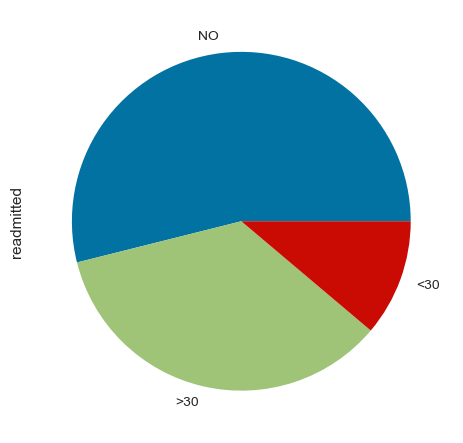

In [14]:
data.readmitted.value_counts().plot.pie()
plt.show()

# Traitement nécessaire avant exploration des données

## Analyse des caractères anormaux du dataframe

Nous observons deux types de données que nous qualifions d'anormaux : 
- des "?" que nous allons remplacer par des NaN 
- des "None" dont nous allons devoir analyser la nature et déterminer la signification

### Les points d'interrogation

In [15]:
# Colonnes avec points d'interrogation

columns_with_special_character(data, '?')

La colonne "race" en contient : 2273
La colonne "weight" en contient : 98569
La colonne "payer_code" en contient : 40256
La colonne "medical_specialty" en contient : 49949
La colonne "diag_1" en contient : 21
La colonne "diag_2" en contient : 358
La colonne "diag_3" en contient : 1423


In [16]:
# Remplacement des ? par des nan

data = data.replace({'?' : np.nan})
columns_with_special_character(data, '?') # on vérifie qu'on n'a plus de colonnes impactées

### Gestion des valeurs "None"

In [17]:
columns_with_special_character(data, 'None')

La colonne "max_glu_serum" en contient : 96420
La colonne "A1Cresult" en contient : 84748


In [18]:
data['max_glu_serum'].value_counts()

None    96420
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64

Les deux colonnes impactées par ces None concernent les prises de sang liées à la mesure du glucose. Après vérification dans la littérature et analyse de la variable, cela signifie que le test n'a pas été effectué. Cela est différent que de ne pas avoir la donnée (Nan). Le test n'a sûrement pas été réalisé pour des raisons médicales. Il est donc intéressant de conserver cette donnée comme modalité en tant que telle. En revanche, au regard du nombre important, il faudra être attentif à la façon dont gérer cette classe déséquilibrée et/ou l'encodage. 

### "Unknown/Invalid"

In [19]:
columns_with_special_character(data, 'Unknown/Invalid')

La colonne "gender" en contient : 3


Il n'y a que 3 modalités, nous la qualifions en Nan et verrons plus tard si nous devons la supprimer ou l'encoder. 

In [20]:
data = data.replace({'Unknown/Invalid' : np.nan})

## Suppression de l'Id

Variable integer inutile qui va parasiter notre modèle.

In [21]:
data = data.drop(columns=['encounter_id'])

## Vérification des doublons

On ne constate aucun doublon.

In [22]:
data.duplicated(keep=False).sum()

0

## Encodage de la target

Notre intérêt ici est de savoir si le patient, lors de son admission, sera de nouveau hospitalisé ou non. Nous ne prenons pas en compte la granularité de temps (à moins ou plus de 30 jours). Nous optons donc pour une variable binaire et non multiclasse.

In [23]:
data = data.replace({'readmitted' : {'NO' : 0, '>30' : 1, '<30' : 1}})

In [24]:
# nb d'exemples pour chaque modalité de la colonne readmitted

data.readmitted.value_counts()

0    54864
1    46902
Name: readmitted, dtype: int64

# Itération 1 : baseline

**Objectif** : créer un modèle prédictif simple, basé sur une analyse exploratoire et une data préparation sommaires afin de comprendre un peu mieux la structure du dataset et de pouvoir élaborer une ébauche de l'application demandée. 

In [43]:
# Copie du dataset nettoyé des informations inutiles

baseline = first_clean_dataset_create_copy()

## Analyse de forme des données

**- Target** : readmitted - la classe est équilibrée (0 : 53% / 1 : 46%)  
**- Lignes et colonnes** : 101766 lignes et  49 colonnes  
**- Types de variables** : int64 = 13, object = 36 dont 5 avec plus de 10 modalités  
**- Valeurs manquantes**: 7 colonnes ont des valeurs manquantes dont 'weight' à hauteur de 96%. 'medical_specialty' et 'payer_code' manquent respectivement à 49% et 40%. 

### Structure du dataset

In [44]:
# Répartition des modalités de la target 'readmitted'
  
analyse_target(baseline)

,number,%
0,54864,53.9
1,46902,46.1


In [45]:
# Nombre de Lignes et colonnes

baseline.shape

(101766, 49)

### Types de variables

A ce stade, nous avons 36 variables qualitatives dont 5 contiennent plus de 10 modalités, et 13 quantitatives.  

In [46]:
baseline.dtypes.value_counts()

object    36
int64     13
dtype: int64

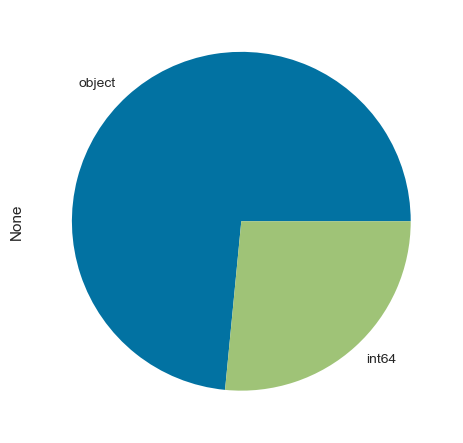

In [47]:
# Répartition du type de variables

baseline.dtypes.value_counts().plot.pie()
plt.show()

In [48]:
analyse_dtypes_object(baseline)

diag_3                      789
diag_2                      748
diag_1                      716
medical_specialty            72
payer_code                   17
age                          10
weight                        9
race                          5
glipizide                     4
glyburide-metformin           4
insulin                       4
miglitol                      4
acarbose                      4
rosiglitazone                 4
pioglitazone                  4
glyburide                     4
chlorpropamide                4
nateglinide                   4
repaglinide                   4
metformin                     4
glimepiride                   4
A1Cresult                     4
max_glu_serum                 4
tolazamide                    3
acetohexamide                 2
glipizide-metformin           2
change                        2
metformin-pioglitazone        2
metformin-rosiglitazone       2
glimepiride-pioglitazone      2
diabetesMed                   2
troglita

### Valeurs nulles

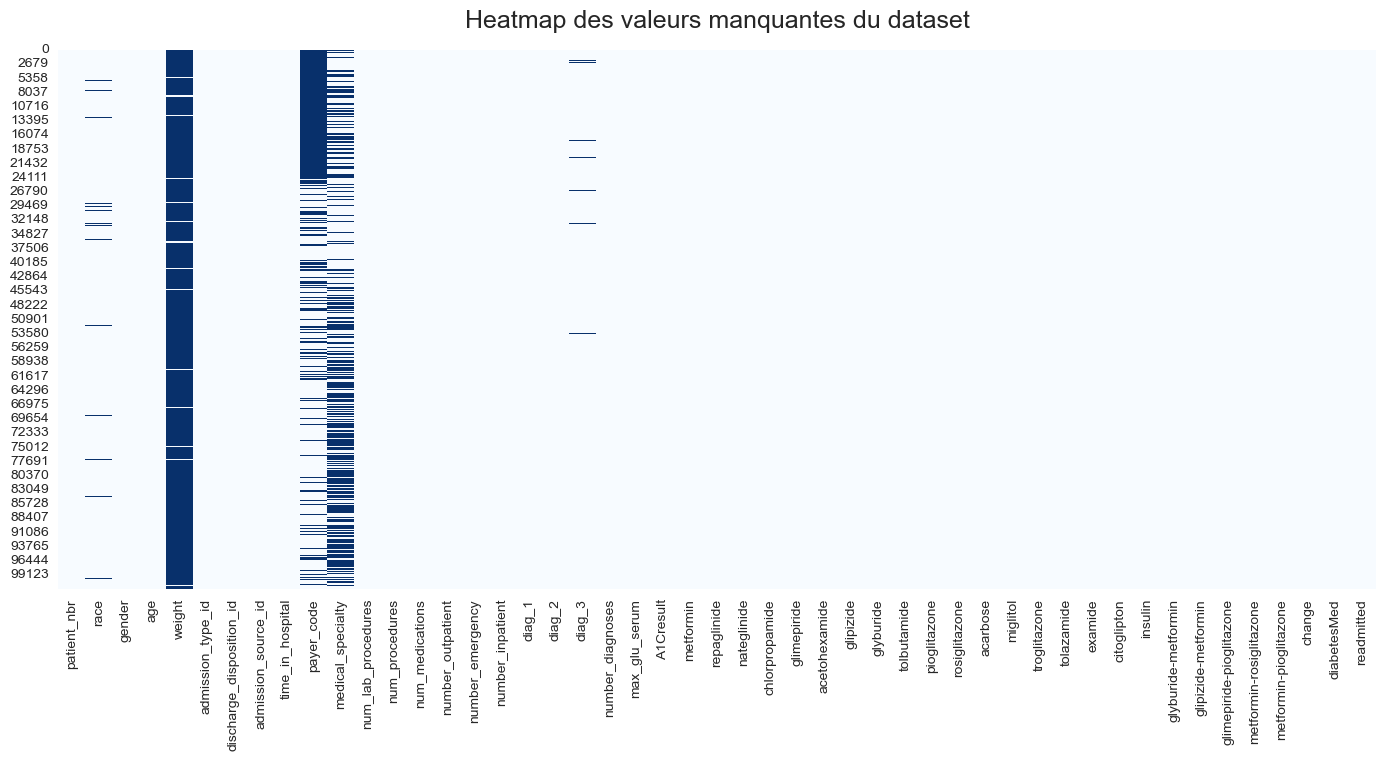

In [49]:
# Cartographie des valeurs nulles 

map_missing_values(baseline)

In [50]:
# Pourcentage de valeurs nulles

check_null_values(baseline)

,nombre_null,%_null
weight,98569,96.9
medical_specialty,49949,49.1
payer_code,40256,39.6
race,2273,2.2
diag_3,1423,1.4
diag_2,358,0.4
diag_1,21,0.0
gender,3,0.0
patient_nbr,0,0.0
tolazamide,0,0.0


7 colonnes ont des valeurs manquantes dont 'weight' à hauteur de 96%. 'medical_specialty' et 'payer_code' manquent respectivement à 49% et 40%.

## Pre-processing

### Suppression des valeurs nulles

Pour notre modèle experimental (baseline), nous décidons de supprimer les colonnes qui ont plus de 30% de valeurs nulles (weight, medical_specialty, payer_code) et toutes les lignes possédant au moins une valeur nulle. 
Notre dataset se compose désormais de 98 052 exemples et 46 colonnes.

In [51]:
# Suppression des colonnes ayant plus de 30% de valeurs nulles (isna)
# Suppression des lignes ayant au moins une valeur nulle(dropna)

baseline = baseline[baseline.columns[baseline.isna().sum()/baseline.shape[0] <0.3]]
baseline = baseline.dropna()

In [52]:
check_null_values(baseline)

,nombre_null,%_null
patient_nbr,0,0.0
tolazamide,0,0.0
acetohexamide,0,0.0
glipizide,0,0.0
glyburide,0,0.0
tolbutamide,0,0.0
pioglitazone,0,0.0
rosiglitazone,0,0.0
acarbose,0,0.0
miglitol,0,0.0


In [53]:
baseline.shape

(98052, 46)

### Transformation de la variable "age"

La colonne "age" est classée selon un intervalle avec 10 modalités (object). 
Point d'attention : cette donnée perd en qualité car on ne sait pas comment la donnée initiale a été transformée.  
Creuser pour savoir comment traiter une variable qui a été encodée selon un intervalle. En attendant, nous allons la transformer en variable numérique en prenant la moyenne des extrêmes de l'intervalle. On aurait pu aussi envisager de faire un Ordinal encorder. 

In [54]:
baseline = baseline.replace({'age' : 
                            {'[0-10)' : 5, 
                             '[10-20)' : 15, 
                             '[20-30)' : 25, 
                             '[30-40)' : 35, 
                             '[40-50)' : 45,
                             '[50-60)' : 55,
                             '[60-70)' : 65,
                             '[70-80)' : 75,
                             '[80-90)' : 80, 
                             '[90-100)' : 95}
                            })

In [55]:
baseline['age'].dtypes

dtype('int64')

### Sélection des variables et split

De notre baseline, nous voulions exclure :    
- les variables qui n'ont qu'une modalité (examide/citoglipton) car elles n'apportent rien au modèle
- les variables à plus de 10 modalités (diag_1/2/3) car elles vont créer de multiples dimensions lors de l'encodage, ce qui peut être lourd et et créer du bruit dans notre algorithme de régression logistique
- la variable "patient_nbr" qui est un ID unique

Et donc conserver certaines variables qualitatives (encodées). Or, cela perturbait notre modèle. Le temps d'exécution était très long et le score restait le même avec ou sans. De ce fait, pour cette première itération/baseline, je n'ai entrainé mon modèle qu'avec les features numériques (hors discharge_disposition_id, admission_source_id, admission_type_id qui sont des integer mais correspondant à des modalités).  

In [56]:
baseline = baseline.drop(columns=['diag_3', 'diag_2', 'diag_1', 'citoglipton', 'examide', 'metformin-rosiglitazone', 'patient_nbr'], axis=1)

In [57]:
baseline.shape

(98052, 39)

In [58]:
# Création du X et du y avec les seules variables quantitatives

# X = baseline.drop(columns=['readmitted'], axis=1)
X = baseline[['time_in_hospital','num_lab_procedures','num_procedures','num_medications',
              'number_outpatient','number_emergency', 'number_inpatient', 'number_diagnoses','age']]
y = baseline[['readmitted']]

In [59]:
# Split du dataset entre un jeu de données de train et de test

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=5, stratify=y)

print('Train set :', X_train.shape)
print('Test set :', X_test.shape)

Train set : (78441, 9)
Test set : (19611, 9)


### Encodage et normalisation (pipeline)

On crée un pipeline de pré-processing de façon à pouvoir transformer nos données plus facilement, et éviter d'avoir de la fuite de données (dataleakage) ou des données mal transformées. 

Pour le variables catégorielles, nous avions choisi d'utiliser le OneHotEncoder même si après l'EDA, il sera certianement plus pertinent parfois de faire un OrdinalEncoder (mettre un poids en fonction du degré d'importance).

Dans notre baseline, nous n'avons que des variables numériques, que nous allons standardiser (moyenne de 0 et écart-type de 1). En effet, les algorithmes de régression fonctionnent mieux sur des données standardisées. 

In [60]:
# Distinction entre les variables numériques et catégorielles

numerical_features = X.select_dtypes(include=['float', 'integer']).columns.values
categorical_features = X.select_dtypes(include=['object']).columns.values

In [61]:
numerical_features

array(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'age'], dtype=object)

In [62]:
# handle_unknown = 'ignore' : pallier au fait que nous n'avons pas dans le X_test le même nombre de classes/modalités

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(sparse = False,  handle_unknown = 'ignore'))

In [63]:
# make_column_transformer : permet d'appliquer les transformers sur les colonnes qu'on sélectionne

preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                   (categorical_pipeline, categorical_features))

In [64]:
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 array(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'age'], dtype=object)),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 array([], dtype=object))])

## Entrainement du modèle et score

### Choix théorique du modèle et des métriques de performanec

#### La régression logistique

Nous choisissons la régression logistique binaire comme premier estimateur pour construire notre premier modèle, pour sa simplicité d'exécution et de son interprétation. L'algorithme va nous permettre d'estimer la probabilité qu'une observation appartienne à la classe négative 0 (proba inf. à 50%) ou la classe positive 1 (prob sup. à 50%).

#### Les métriques de performance choisies : fonctions coût et algorithme de minimisation

Notre application d'aide à la décision médicale a pour objectif de prédire si un patient admis pour diabète sera de nouveau hospitalisé ou non. L'intérêt médical est de pouvoir assurer un suivi particulier et d'être vigilent envers les patients topés positif. 
Dans ce contexte, il nous faut donc éviter les faux négatifs : on ne veut pas prédire qu'une personne ne retournera pas l'hôpital alors qu'elle reviendra. Il est préférable qu'on dise qu'elle vienne, même si c'est une fausse alerte, plutôt que de penser qu'elle ne fera pas de nouveau une crise de diabète. Nous allons donc nous attacher à obtenir un bon RECALL.   
En revanche, nous ne voulons pas non plus que les hôpitaux soient "surchargés" par une masse de travail et un suivi précis de patients, donc il nous faut également limiter les faux positifs. Nous veillerons donc également à obtenir une PRECISION convenable.  
Dans la mesure où nous avons besoin d'un rapport entre la precision et le recall honorable, nous avons tout intérêt à veiller à ce que notre F1 SCORE soit optimisé (il calcule le rapport moyen entre les 2 métriques grâce à une moyenne harmonique).  
Enfin, nous serons attentifs à l'ACCURACY, qui nous permettra de vérifier la part de bonnes prédictions. 

S'agissant de l'algorithme qui va aider notre modèle à minimiser cette fonction coût, nous utiliserons pour le moment celle implémentée dans le module Logistic Regression de Sklearn, qui est celle des moindres carrés. Au regard de la taille de notre dataset, nous envisagerons lors d'une seconde itération d'appliquer le Stochastic Gradient Descent Classifier qui nous permettra d'appliquer l'algorithme de minimisation de la Descente de gradient et d'en ajuster les paramètres.  

### Entraînement & score en cross validation

#### Création du modèle avec le pipeline de preprocessing

In [65]:
# Choix du model et pipeline de pre-processing

model_rlog = make_pipeline(preprocessor, LogisticRegression(random_state = 5, solver='lbfgs')) # solver='lbfgs' mis suite à message d'erreur

#### Evaluation du modèle et learning curve

Score accuracy en cv : [0.61265855 0.61480112 0.61352626 0.61607598 0.61390872]
Score accuracy moyen en cv : 0.6141941272494826

Score recall en cv : [0.39398496 0.39198797 0.39403883 0.39732021 0.39097744]
Score recall moyen en cv : 0.39366188235148986

Score precision en cv : [0.63676536 0.64239301 0.6385996  0.64277815 0.64096818]
Score precision moyen en cv : 0.6403008576390216

Score f1 en cv : [0.48678321 0.48688121 0.48735943 0.49108576 0.48569245]
Score f1 moyen en cv : 0.4875604131558874

Pour accuracy :


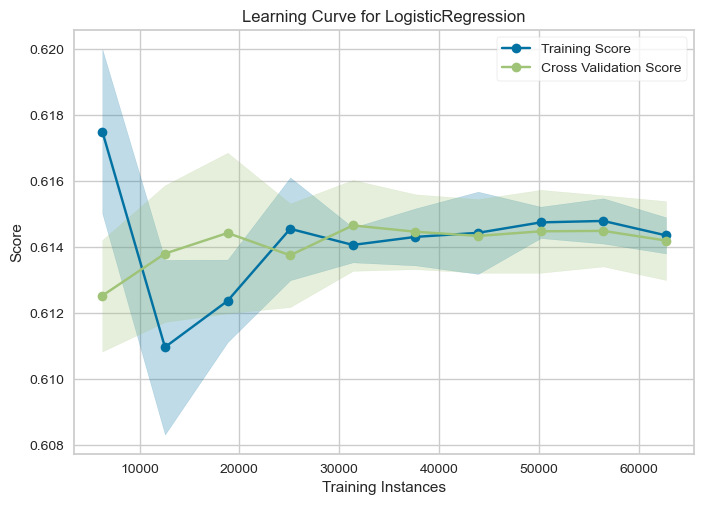

------------------------------------------------
Pour recall :


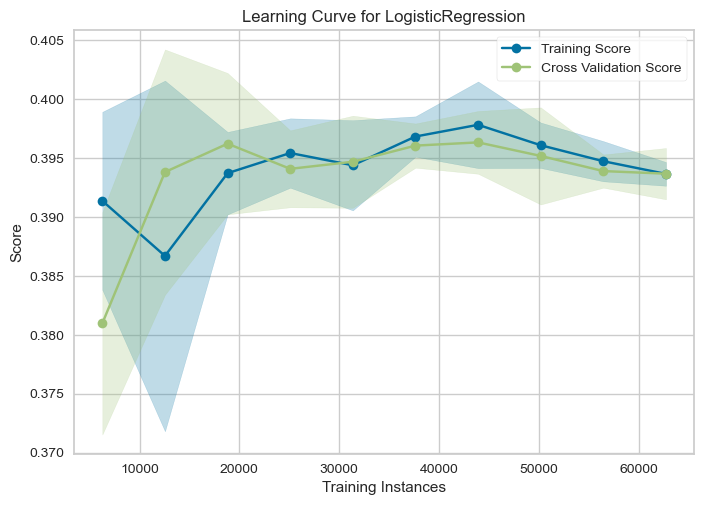

------------------------------------------------
Pour precision :


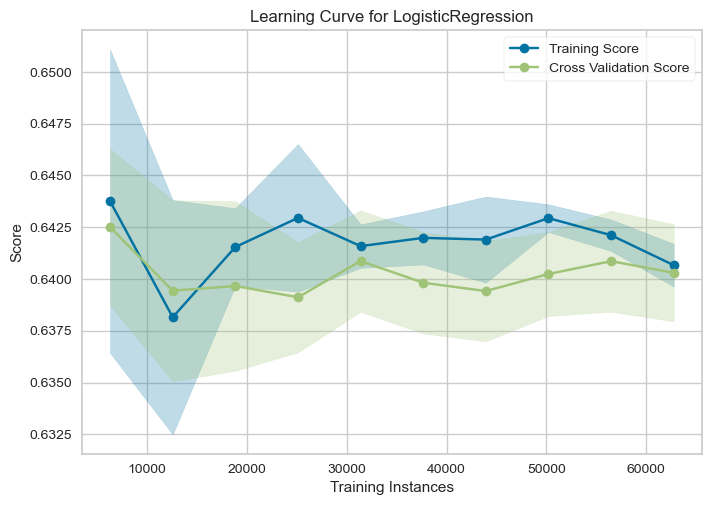

------------------------------------------------
Pour f1 :


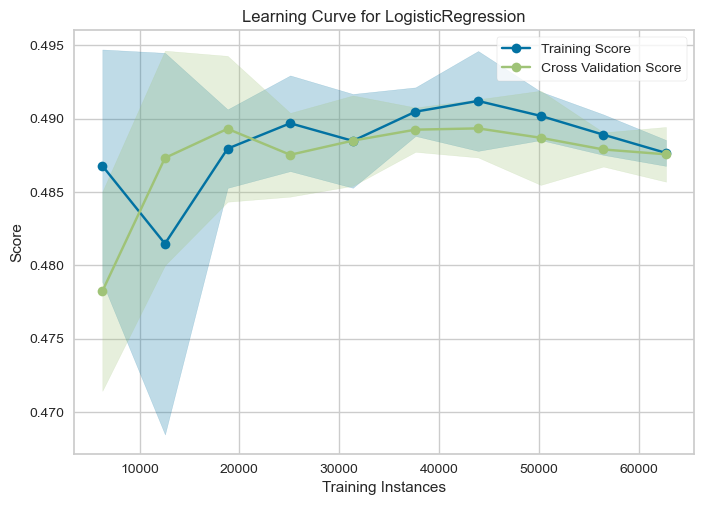

------------------------------------------------


In [66]:
# Evaluation du modèle avec les 4 métriques et analyse de la learning curve

evaluation_cv(model_rlog, X_train, y_train.values.ravel())

**Recall**:    

Le score est de 0,39 en cross validation : pour toutes le observations actuellement positives (y_true), 39% ont été correctement classifiées. Ce qui est mauvais. L'objectif de la learning curve est de comprendre la structure de la donnée et d'avoir un train qui baisse (le modèle ne surapprend pas) et un test qui augmente (ce qui montre une bonne généralisation). Dans le cas du recall, on observe une convergence du train et du validation set à mesure que la donnée augmente, ce qui pourrait supposer une bonne généralisation.

Les zones ombrées autour des courbes mettent en avant la variabilité (écart-type au dessus et en dessous de la moyenne). La variabilité semble légèrement plus grande autour du train, ce qui laisse supposer que nous avons un problème de biais, confirmé par les mauvais résultats sur le train et le validation set. Nous avons de grandes erreurs sur les deux courbes, notre modèle ne parvient pas à faire de relations pertinentes entre les données lorsqu'il s'agit de minimiser les faux négatifs. A noter une plus grande variance encore sur le train en début d'entrainement, pouvant s'expliquer par un manque de données. 

Notre modèle souffre d'underfitting. 

**Precision**:

Le score est de 0,69 : pour toutes les observations classées en positif, 69% sont corrects.  
Il est meilleur que le recall. Avec une learning curve qui se comporte à peu près de la même façon que le recall. Notre modèle souffre de biais et est en underfitting.  

**Accuracy** :

Notre modèle explique à 61% la variance de notre target. Il est honorable mais doit être amélioré et ne peut être considéré comme fiable. 


**Conclusion** : 
Notre modèle gère mieux les prédictions lorsqu'il s'agit de minimiser les faux positifs, c'est à dire prédire qu'une personne reviendra en hospitalisation alors que ce ne sera pas le cas. Nous voulons atteindre cet objectif mais pas prioritairement, nous allons donc nous attacher à améliorer le score en recall. 
Il souffre clairement d'underfitting, ne parvenant pas à saisir les patterns de notre modèle.

**Pistes d'amélioration à envisager** :
- optimiser les hyperparamètres afin de mieux "guider" l'algorithme ou choisir un modèle plus puissant avec plus de paramètres
- fournir davantage de variables au modèle 
- fournir de meilleures variables à l'algorithme d'apprentissage (voir les transformations possibles) grâce à l'exploration des données (EDA)

- la regression logistique étant un modèle paramétrique, il conviendrait de vérifier que les principaux présupposés sont bien respectés, notamment la normalité et homoscédasticité des résidus

#### Matrice de confusion en cv

La matrice de confusion permet de comparer les résultats du modèle (prédictions) avec les valeurs réelles. 
Chaque ligne du tableau correspond à la classe réelle et chaque colonne à la classe prédite. 

In [67]:
y_pred_cv = cross_val_predict(model_rlog, X_train, y_train.values.ravel(), cv=5)
y_pred_cv

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [68]:
# Confusion matrix (on compare y_true et y_pred)
# Question : est-ce judicieux de faire la confusion matrix avec le y_train (non crossé et le y_pred_cv) ?

conf_cv = pd.DataFrame(confusion_matrix(y_train, y_pred_cv))
conf_cv = conf_cv.rename(columns={0: 'Predicted 0',1:'Predicted 1'})
conf_cv= conf_cv.rename(index={0: 'Actual 0',1:"Actual 1"})
conf_cv 

,Predicted 0,Predicted 1
Actual 0,33781,8088
Actual 1,22175,14397


Notre modèle fait de grosses erreurs lorsqu'il s'agit de prédire les vrais positifs : il a prédit que 22175 personnes ne seraient pas réhospitalisées alors que c'est le cas. Cela corrobore notre mauvais score sur le recall.  

#### Classification report

In [69]:
# Classification report (classification_report(y_true, y_pred))

print(classification_report(y_train, y_pred_cv))

              precision    recall  f1-score   support

           0       0.60      0.81      0.69     41869
           1       0.64      0.39      0.49     36572

    accuracy                           0.61     78441
   macro avg       0.62      0.60      0.59     78441
weighted avg       0.62      0.61      0.60     78441



Interprétation du recall pour les 0 : parmi les observations actuellement négatives, 81% ont été correctement classifiées par mon modèle.  

### Score sur le train et le test

#### Score

In [ ]:
# Faire fonction où on fit/score/classification report/prédiction ? 

In [71]:
# Entrainement
model_rlog.fit(X_train, y_train.values.ravel()) 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  array(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'age'], dtype=object)),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  array([], dtype=object))])),
                ('logisticregression', LogisticRegression(random_state=5))])

In [72]:
# score sur le test

score_test = model_rlog.score(X_test,y_test)
score_test

0.6102697465708021

In [73]:
# Classification report sur le test

y_pred = model_rlog.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.80      0.69     10468
           1       0.63      0.39      0.48      9143

    accuracy                           0.61     19611
   macro avg       0.62      0.60      0.59     19611
weighted avg       0.62      0.61      0.59     19611



#### Courbe AUC/ROC

Elle met en corrélation le taux de faux positifs et le taux de vrais positifs.
Elle représente la performance attendue pour une estimation totalement aléatoire pour chaque patient, ce qui reviendrait à tirer à pile ou face : on peut s'attendre à un résultat correct dans la moitié des cas et incorrect dans l'autre moitié. La zone sous la ligne diagonale représente donc un AUC de 0.5. Si l’AUC est supérieure à O.5 pour un modèle de classification binaire, alors il est plus performant qu’une estimation aléatoire. La zone sous la courbe est une mesure de discrimination : plus elle est important, plus le modèle est capable de prévoir correctement la valeur de la réponse de l'observation.

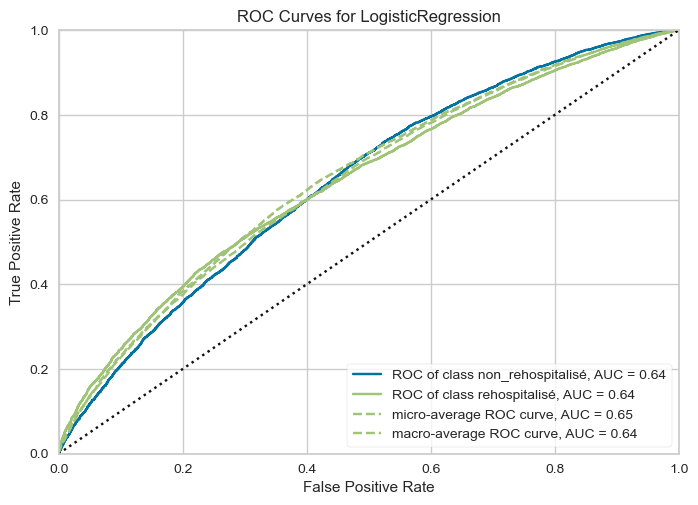

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [74]:
visualizer = ROCAUC(model_rlog, classes=["non_rehospitalisé", "rehospitalisé"])

visualizer.fit(X_train, y_train)       
visualizer.score(X_test, y_test)      
visualizer.show()  

Notre modèle est considéré comme plus performant qu'une simple prédiction aléatoire car supérieur à 0.5. Néanmoins, étant inférieur à 0.7, on en conclut qu'il ne fournit pas de discrimination appropriée, suffisante.  

### Score sur l'ensemble du data set

In [75]:
# model.fit(X, y)

model_rlog.fit(X,y.values.ravel())

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  array(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'age'], dtype=object)),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  array([], dtype=object))])),
                ('logisticregression', LogisticRegression(random_state=5))])

In [76]:
model_rlog.score(X, y)

0.61320523803696

### Predict

In [77]:
# Renvoie la prediction du label en fonction de X

y_hat = model_rlog.predict(X)
y_hat

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [78]:
# Renvoie une probabilité pour chaque label
# Interprétation : L'item 25 a 56% d'appartenir à la classe 0 et 43% d'appartenir à la classe 1.

y_hat_proba = model_rlog.predict_proba(X)
y_hat_proba

array([[0.58871351, 0.41128649],
       [0.5935229 , 0.4064771 ],
       [0.63391872, 0.36608128],
       ...,
       [0.47487941, 0.52512059],
       [0.46528722, 0.53471278],
       [0.61193983, 0.38806017]])

## Pistes d'amélioration pour les itérations suivantes

Pour le choix du modèle : 
- la regression logistique étant un modèle paramétrique, il conviendrait de vérifier que les principaux présupposés :
    - échantillon représentatif
    - absence de multicolinéarité (tests avec le VIF par exemple)
    - normalité des résidus (voir comment afficher les résidus d'une classification binaire)
    - homoscédasticité des erreurs (variance)
- à défaut, utiliser un modèle non paramétrique tel que le DecisionTreeClassifier : si on obtient les mêmes scores, on en déduit que les présupposés de la régression logisitique sont réunis
- si la question des présupposés est remplie, tester le SGD Classifier afin d'utiliser un modèle plus puissant qui permet d'appliquer la Descente de Gradient (stochastique) 

Pour enrayer l'underfiting : 
- optimiser les hyperparamètres afin de mieux "guider" l'algorithme 
- choisir un modèle plus puissant avec plus de paramètres (SDG Classifier ou XGBoost Classifier)
- fournir davantage de variables au modèle
- fournir de meilleures variables à l'algorithme d'apprentissage (voir les transformations possibles) grâce à l'exploration des données (EDA)



### Sauvegarde du modèle avec Joblib

D'après la documentation Sklearn (https://scikit-learn.org/stable/model_persistence.html), Joblib est plus efficace que piclke quand il s'agit de sauvegarder des modèles basés sur des algorithmes qui ont de nombreux paramètres et qui reposent sur de grands datasets. 

In [ ]:
import joblib 

In [ ]:
# Sauvegarde du modèle sous le fichier nommé 'model_joblib'

joblib.dump(model, 'model_joblib')

In [ ]:
# Lecture du modèle enregistré dans le fichier

model_joblib = joblib.load('model_joblib')

In [ ]:
# Visualisation du modèle tel qu'il a été enregistré

model_joblib

In [ ]:
# Test de prediction ave le modèle encapsulé dans le fichier joblib

prediction_joblib = model_joblib.predict(X)
prediction_joblib

# Itération 2

## EDA

In [79]:
# Veiller à runner les modifications faites dans data directement

df = data.copy()

In [80]:
df.head()

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
1,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,1
2,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0
3,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0
4,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0


### Analyse de forme

- Identification de la target : readmitted
- Nb lignes et colonnes : 101766 lignes et 49 colonnes
- Types de variables : 13 variables quantitatives et 36 catégorielles
- Identification des valeurs manquantes : 
    - pas bcp de colonnes avec des Nan
    - colonne "weight" >96% de Nan
    - "3 diag" à analyser pour voir s'il existe logique dans les NAN car correspondent à des diagnostiques additionnels
    - payer_code"/medical_specialty : 40% / 50% de Nan => voir si relation entre l'assurance et la spécialité du médecin

In [82]:
df.shape

(101766, 49)

In [83]:
df.dtypes.value_counts()

object    36
int64     13
dtype: int64

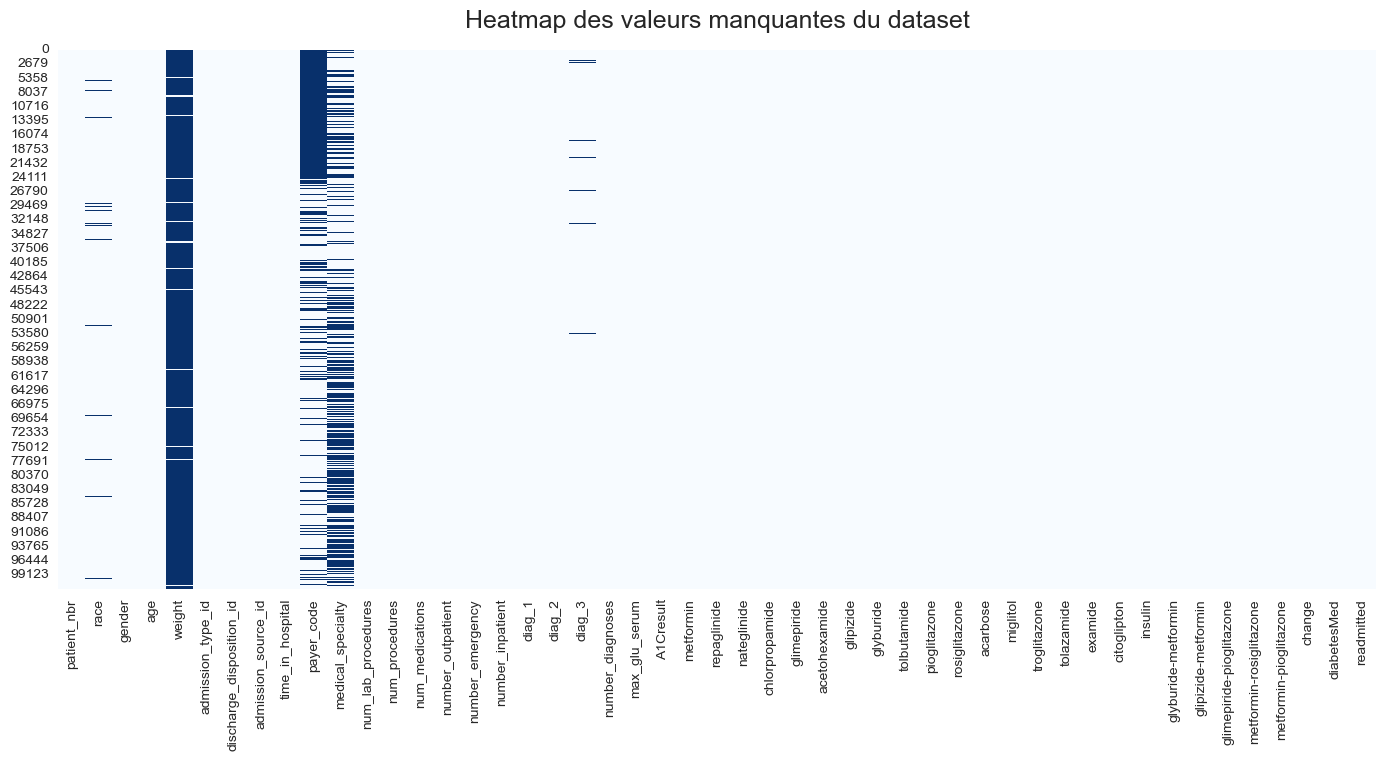

In [84]:
map_missing_values(df)

**Interprétation:**    

Valeurs manquantes (en noir):  
- Pas beaucoup de valeurs manquantes, sauf pour la colonne weight > 96% => sera sûrement à supprimer.  
- les 3 diag n'ont seulement que quelques valeurs manquantes => voir si cela est normal dans la hiérarchie et la compréhension de la variable (diag1, puis diag2 puis diag2) => dropna ?
- payer code et medical_specialty ont quasiment le même nombre de valeurs nulles => voir s'il existe une relation entre elles (quand figuration ainsi, souvent c'est qu'il y a une relation - cf. Machine Learnia)

In [85]:
check_null_values(df)

,nombre_null,%_null
weight,98569,96.9
medical_specialty,49949,49.1
payer_code,40256,39.6
race,2273,2.2
diag_3,1423,1.4
diag_2,358,0.4
diag_1,21,0.0
gender,3,0.0
patient_nbr,0,0.0
tolazamide,0,0.0


### Analyse de fond

#### Elimination des colonnes inutiles

In [86]:
# Suppression des colonnes avec valeurs nulles > 90% 

df = df[df.columns[df.isna().sum()/df.shape[0] <0.9]]

In [87]:
df.shape

(101766, 48)

In [ ]:
# On conserve le patient_nbr (id) car cela nous permettra de calculer le nombre de fois où un patient a été hospitalisé.

# Idées en vrac

- Pour le nettoyage des données : 
    - Voir comment gérer la colonne 'race' : pour le même id = pas la même race attribuée
- Feature engineering 
    - nb d'admissions par patient mais sera sûrement biaisé car fortement corrélé à la target : si le patient présente plusieurs lignes dans le dataset, c'est forcément qu'il a été réadmis. Il serait peut-être plus intéressant de noter la différence de traitement entre les différentes admissions (augmentation de la glycémie à jeun/glyquée, différence de traitement)
    - Gestion des 3 variables id encodées en ordinal mais qui sont en réalité des catégorielles. Les passer en string puis les encoder en OneHot. Ex : baseline['admission_type_id'].map(lambda x: str(x))
- Gestion des variables qualitatives 
    - cross_tab Khi 2
- precision-recall curve : Après avoir trouvé le bon modèle et régler les hyperparamètres, gérer le bon threshold entre la precision et le recall grace au  : https://www.scikit-yb.org/en/latest/api/classifier/prcurve.html